## **1. Importing Required Libraries**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2
from skimage.data import camera, astronaut
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.transform import resize

## **2. Why Does Phase Matter?**

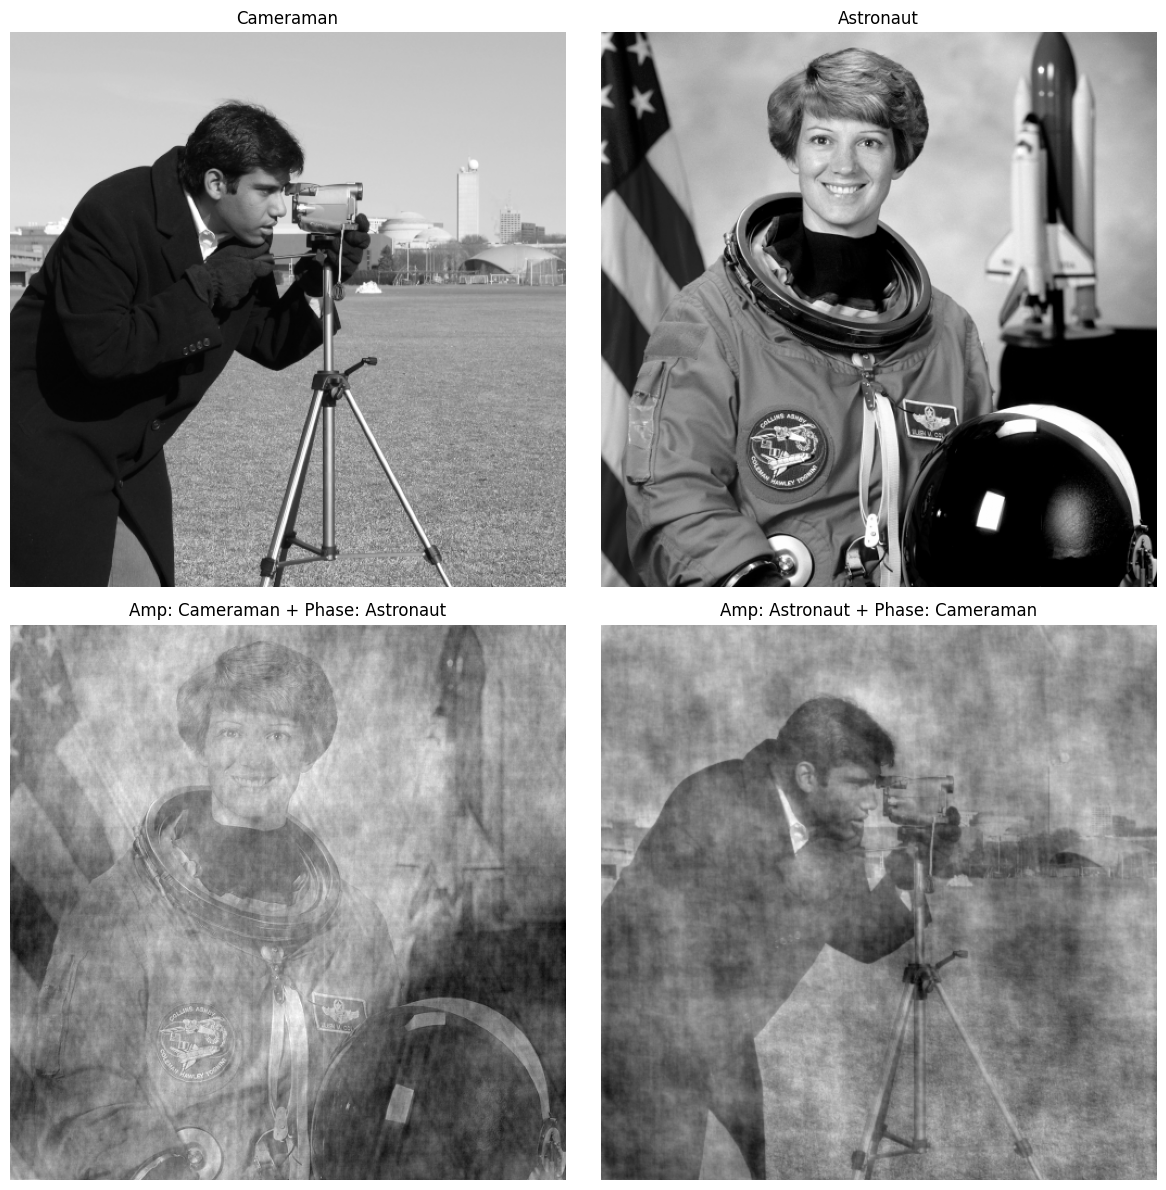

In [6]:
# Load the Cameraman image (grayscale)
image1 = img_as_float(camera())

# Load the Astronaut image (RGB)
image2 = img_as_float(astronaut())

# Convert grayscale image to RGB (for compatibility with resize)
image1_rgb = np.stack([image1]*3, axis=-1)  # Convert to 3-channel

# Find the larger dimensions
max_height = max(image1_rgb.shape[0], image2.shape[0])
max_width = max(image1_rgb.shape[1], image2.shape[1])

# Resize both images to the same dimensions
image1_resized = resize(image1_rgb, (max_height, max_width), anti_aliasing=True)
image2_resized = resize(image2, (max_height, max_width), anti_aliasing=True)

# Convert both to grayscale
gray1 = rgb2gray(image1_resized)
gray2 = rgb2gray(image2_resized)

# Fourier transform
fft1 = np.fft.fft2(gray1)
fft2 = np.fft.fft2(gray2)

# Extract amplitude and phase
amplitude1, phase1 = np.abs(fft1), np.angle(fft1)
amplitude2, phase2 = np.abs(fft2), np.angle(fft2)

# Swap phase and reconstruct
reconstructed1 = np.fft.ifft2(amplitude1 * np.exp(1j * phase2)).real
reconstructed2 = np.fft.ifft2(amplitude2 * np.exp(1j * phase1)).real

# Normalize reconstructed images to [0, 1]
reconstructed1 = (reconstructed1 - reconstructed1.min()) / (reconstructed1.max() - reconstructed1.min())
reconstructed2 = (reconstructed2 - reconstructed2.min()) / (reconstructed2.max() - reconstructed2.min())

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Original images
axes[0, 0].imshow(gray1, cmap="gray")
axes[0, 0].set_title("Cameraman")
axes[0, 0].axis("off")

axes[0, 1].imshow(gray2, cmap="gray")
axes[0, 1].set_title("Astronaut")
axes[0, 1].axis("off")

# Reconstructed images
axes[1, 0].imshow(reconstructed1, cmap='gray')
axes[1, 0].set_title("Amp: Cameraman + Phase: Astronaut")
axes[1, 0].axis("off")

axes[1, 1].imshow(reconstructed2, cmap='gray')
axes[1, 1].set_title("Amp: Astronaut + Phase: Cameraman")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


## **3. Phase Retrieval Algorithm**

### **3.1. Required Functions**

In [7]:
def phase_retrieval(magnitude, support, beta=0.9, max_iter=1000, method='HIO'):
    """
    Perform Fourier phase retrieval using the HIO or ER method.

    Parameters:
        magnitude: 2D numpy array
            Fourier magnitude of the original image.
        support: 2D numpy array
            Binary mask defining the support constraint.
        beta: float, optional
            Feedback parameter for HIO (default: 0.9).
        max_iter: int, optional
            Number of iterations (default: 1000).

    Returns:
        2D numpy array
            Reconstructed image.
    """
    # Initialize random phase and Fourier guess
    phase = np.exp(1j * 2 * np.pi * np.random.rand(*magnitude.shape))
    G = magnitude * phase  # Initial guess in Fourier space
    g_prev = np.zeros_like(magnitude, dtype=np.complex64)

    output_each_iter = []

    for _ in range(max_iter):
        # Transform to spatial domain
        g = np.real(ifft2(ifftshift(G)))

        # Apply support constraint
        if method == 'HIO':
            g_new = np.where(support, g, g_prev - beta * g)
        elif method == 'ER':
            g_new = np.where(support, g, 0)


        # Enforce magnitude constraint in Fourier domain
        G = np.fft.fftshift(np.fft.fft2(g_new))
        G = magnitude * np.exp(1j * np.angle(G))

        # Save current reconstruction
        output_each_iter.append(np.real(ifft2(ifftshift(G))))

        # Update previous spatial domain image
        g_prev = g_new

    return output_each_iter


In [8]:
def zero_pad_image(image):
    # Original dimensions
    original_height, original_width = image.shape

    # New dimensions
    new_height, new_width = original_height * 2, original_width * 2

    # Create zero-padded matrix
    padded_image = np.zeros((new_height, new_width))

    # Calculate start and end indices for centering the image
    start_h = (new_height - original_height) // 2
    start_w = (new_width - original_width) // 2

    # Place the original image in the center
    padded_image[start_h:start_h + original_height, start_w:start_w + original_width] = image

    # Create the support matrix
    support_matrix = np.zeros_like(padded_image)
    support_matrix[start_h:start_h + original_height, start_w:start_w + original_width] = 1

    return padded_image, support_matrix

In [9]:
def crop_padded_image(padded_image, original_shape):
    # Extract the original dimensions
    original_height, original_width = original_shape

    # Calculate the start and end indices for cropping the image
    start_h = (padded_image.shape[0] - original_height) // 2
    start_w = (padded_image.shape[1] - original_width) // 2

    # Crop the padded image to the original size
    cropped_image = padded_image[start_h:start_h + original_height, start_w:start_w + original_width]

    return cropped_image


### **3.2. Loading Cameraman**

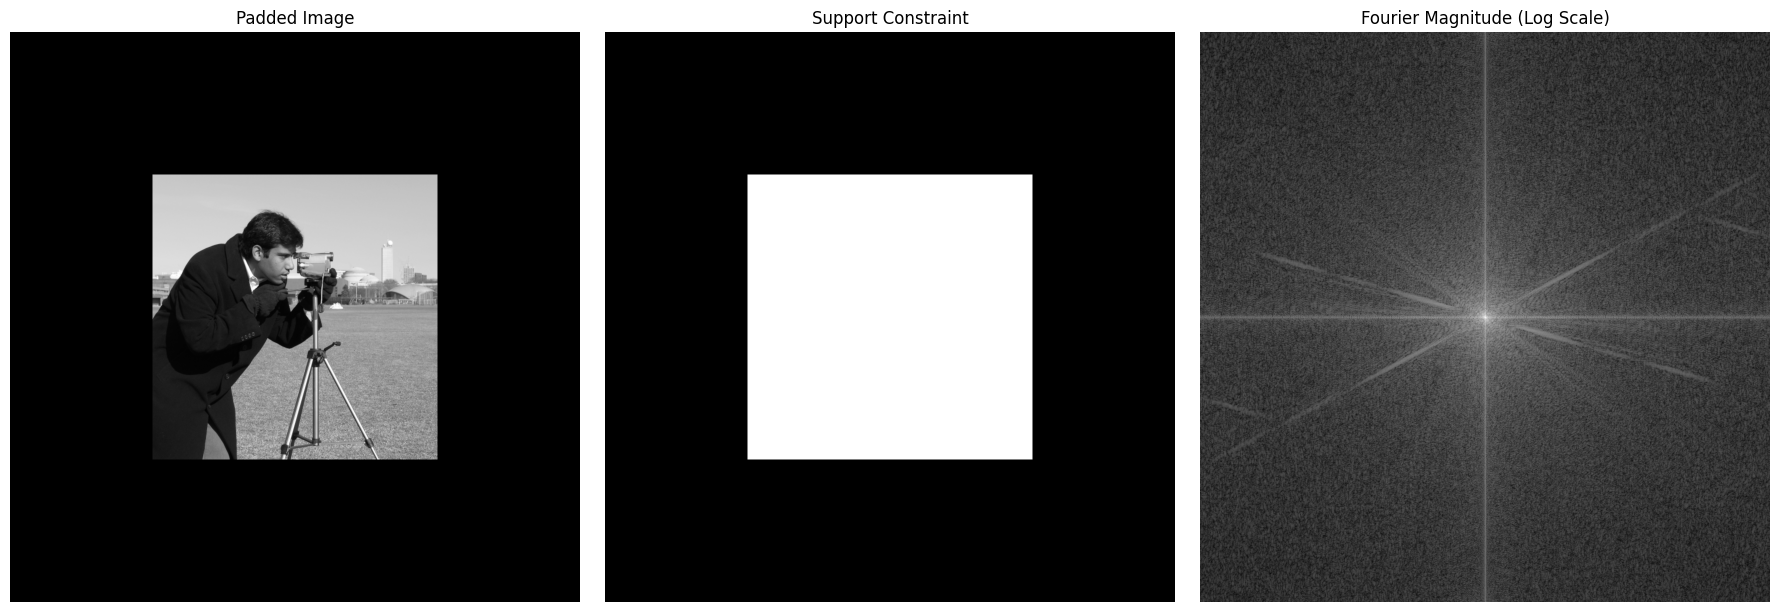

In [10]:
# Load the Cameraman image
image = camera().astype(np.float32)
image /= np.max(image)  # Normalize the image

# Apply zero-padding and create the support matrix
padded_image, support_matrix = zero_pad_image(image)

# Generate the Fourier magnitude
fourier_transform = np.fft.fftshift(np.fft.fft2(padded_image))
magnitude = np.abs(fourier_transform)

# Plot the padded image, support matrix, and Fourier magnitude
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(padded_image, cmap='gray')
axes[0].set_title('Padded Image')
axes[0].axis('off')

axes[1].imshow(support_matrix, cmap='gray')
axes[1].set_title('Support Constraint')
axes[1].axis('off')

# Fourier Magnitude in logarithmic scale for better visualization
axes[2].imshow(np.log1p(magnitude), cmap='gray')
axes[2].set_title('Fourier Magnitude (Log Scale)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### **3.3. Performing ER and HIO on cameraman iamge**

In [ ]:
# Apply ER
reconstructed_image_ER = phase_retrieval(magnitude, support_matrix, beta=0.99, max_iter=800, method='ER')

# Apply HIO
reconstructed_image_HIO = phase_retrieval(magnitude, support_matrix, beta=0.99, max_iter=800, method='HIO')

### **3.4. Visualization of Final Results**

Shape of Reconstructed Image (ER): (800, 1024, 1024)
Shape of Reconstructed Image (HIO): (800, 1024, 1024)


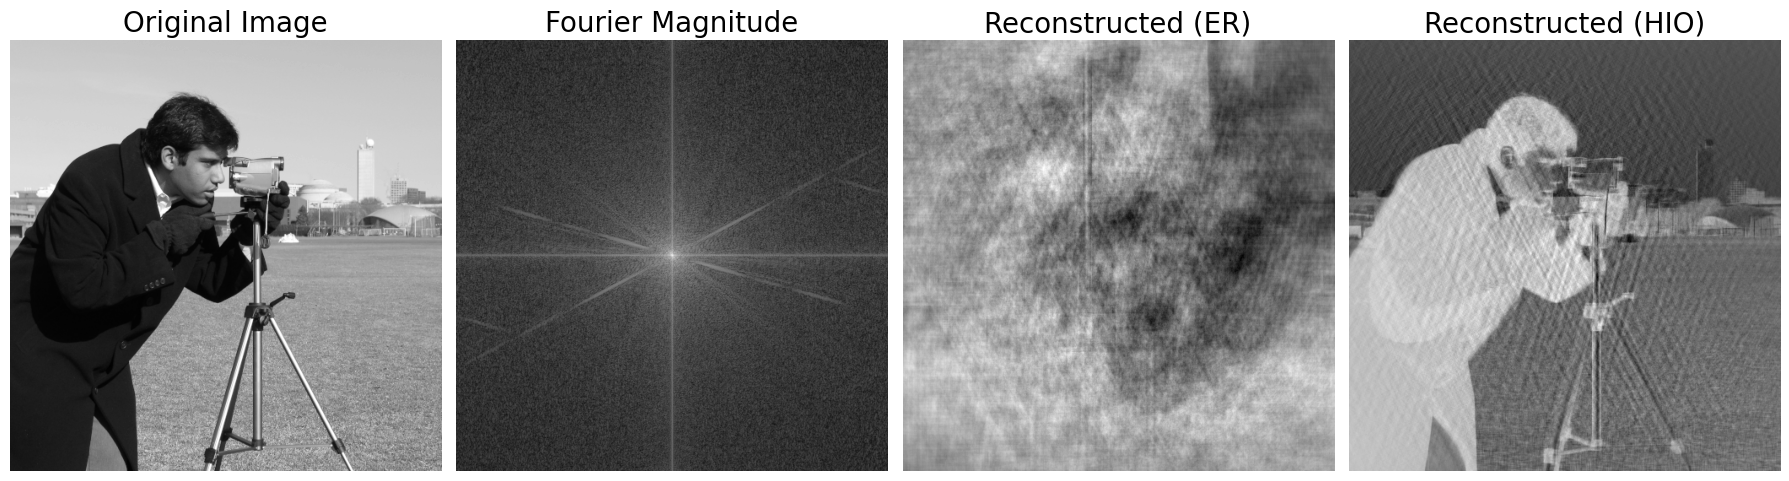

In [ ]:
# Convert reconstructed images to NumPy arrays (if not already)
reconstructed_image_ER = np.asarray(reconstructed_image_ER)
reconstructed_image_HIO = np.asarray(reconstructed_image_HIO)

# Print shapes of reconstructed images
print("Shape of Reconstructed Image (ER):", reconstructed_image_ER.shape)
print("Shape of Reconstructed Image (HIO):", reconstructed_image_HIO.shape)

# Define the original image shape (before padding)
font_size = 20
original_shape = image.shape

# Plot results
plt.figure(figsize=(18, 6))

# Plot Original Image
plt.subplot(1, 4, 1)
plt.title("Original Image", fontsize = font_size)
plt.imshow(image, cmap='gray')
plt.axis('off')

# Plot Fourier Magnitude
plt.subplot(1, 4, 2)
plt.title("Fourier Magnitude", fontsize = font_size)
plt.imshow(np.log1p(magnitude), cmap='gray')  # Use np.log1p for numerical stability
plt.axis('off')

# Plot Reconstructed Image (ER)
plt.subplot(1, 4, 3)
plt.title("Reconstructed (ER)", fontsize = font_size)
# Crop the image back to its original shape
cropped_ER = crop_padded_image(reconstructed_image_ER[-1], original_shape)
plt.imshow(cropped_ER, cmap='gray')
plt.axis('off')

# Plot Reconstructed Image (HIO)
plt.subplot(1, 4, 4)
plt.title("Reconstructed (HIO)", fontsize = font_size)
# Crop the image back to its original shape
cropped_HIO = crop_padded_image(reconstructed_image_HIO[-1], original_shape)
plt.imshow(cropped_HIO, cmap='gray')
plt.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

### **3.5. Making Video**

In [ ]:
# Define video settings
output_file = 'reconstructed_video.mp4'
fps = 30  # Frames per second
frame_size = (512 * 2, 512 * 2)  # 2 by 2 subplot layout

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
video_writer = cv2.VideoWriter(output_file, fourcc, fps, frame_size, isColor=True)

# Define the original image shape (before padding)
original_shape = image.shape

# Generate video frames
for i in range(len(reconstructed_image_ER)):
    # Create a figure for the current iteration
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # Plot Original Image
    axs[0, 0].imshow(image, cmap='gray')
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')

    # Plot Fourier Magnitude
    axs[0, 1].imshow(np.log1p(magnitude), cmap='gray')  # Use np.log1p for numerical stability
    axs[0, 1].set_title("Fourier Magnitude")
    axs[0, 1].axis('off')

    # Plot Reconstructed Image (ER)
    cropped_ER = crop_padded_image(reconstructed_image_ER[i], original_shape)  # Crop the image
    axs[1, 0].imshow(cropped_ER, cmap='gray')
    axs[1, 0].set_title(f"Reconstructed (ER)\nIteration {i + 1}")
    axs[1, 0].axis('off')

    # Plot Reconstructed Image (HIO)
    cropped_HIO = crop_padded_image(reconstructed_image_HIO[i], original_shape)  # Crop the image
    axs[1, 1].imshow(cropped_HIO, cmap='gray')
    axs[1, 1].set_title(f"Reconstructed (HIO)\nIteration {i + 1}")
    axs[1, 1].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Save figure as an image in memory
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

    # Resize the frame to match video dimensions
    frame = cv2.resize(frame, frame_size)

    # Write frame to video
    video_writer.write(frame)

    # Close the figure to free memory
    plt.close(fig)

# Release video writer
video_writer.release()

print(f"Video saved as {output_file}")

<ipython-input-9-d2f44346ac29>:45: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Video saved as reconstructed_video.mp4


### **4. Number of Papers**

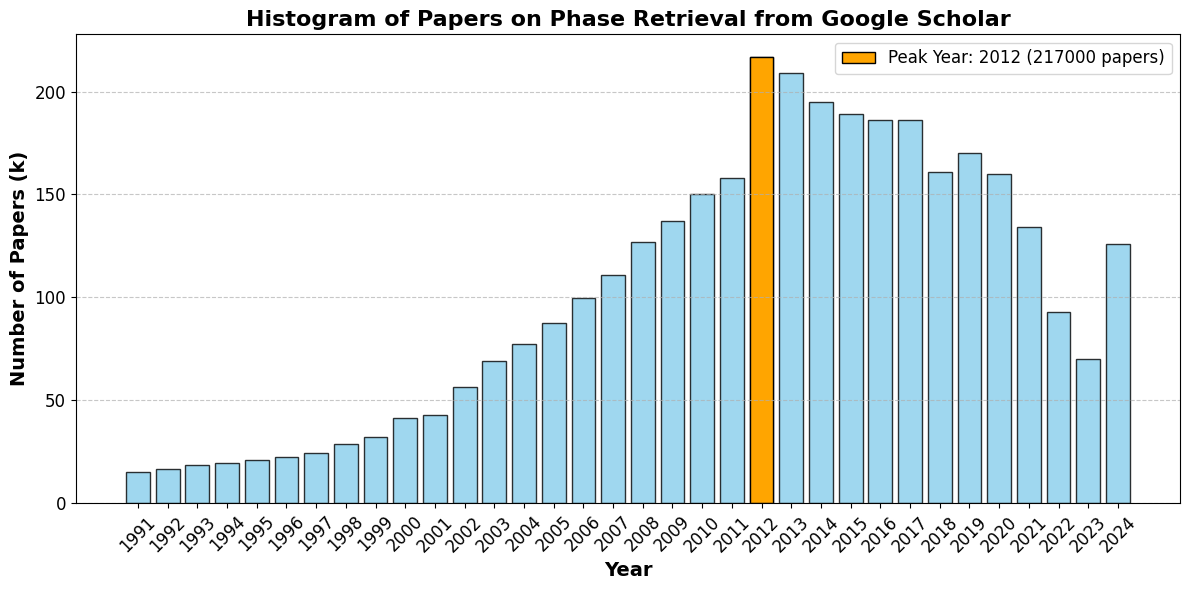

The peak year is 2012 with 217000 papers.


In [ ]:
number_of_papers = [126000, 69800, 93000, 134000, 160000, 170000, 161000, 186000, 186000, 189000, 195000, 209000, 217000, 158000, 150000, 137000, 127000, 111000, 99700, 87600, 77400, 69200, 56200, 42800, 41400, 32000, 28500, 24500, 22600, 21000, 19300, 18300, 16700, 15000]
year = [2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991]

# Ensure data lengths match before plotting
if len(number_of_papers) == len(year):
    # Determine the peak year
    peak_index = np.argmax(number_of_papers)
    peak_year = year[peak_index]
    peak_value = number_of_papers[peak_index]

    # Plot the histogram
    plt.figure(figsize=(12, 6))
    plt.bar(year, np.array(number_of_papers) / 1000, color='skyblue', edgecolor='black', alpha=0.8)

    # Highlight the peak year
    plt.bar(peak_year, peak_value / 1000, color='orange', edgecolor='black', label=f'Peak Year: {peak_year} ({peak_value} papers)')

    # Fancy styling
    plt.xlabel('Year', fontsize=14, weight='bold')
    plt.ylabel('Number of Papers (k)', fontsize=14, weight='bold')  # Y-axis label updated
    plt.title('Histogram of Papers on Phase Retrieval from Google Scholar', fontsize=16, weight='bold')
    plt.xticks(year, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Show the plot
    plt.show()

    print(f"The peak year is {peak_year} with {peak_value} papers.")
else:
    print("Error: The lengths of 'number_of_papers' and 'year' do not match.")
